In [1]:
from functools import partial
from math import exp, log
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from cvxopt import matrix
from cvxopt.blas import dot
from cvxopt import solvers

/home/ben/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def gen_samples(dist_type):
    if dist_type == 'normal':
        def gen_norm_samples(nums, mu, sigma):
            return np.random.randn(nums) * sigma + mu
        return gen_norm_samples

In [3]:
gen_norm_samples = gen_samples('normal')

In [4]:
sample_func = partial(gen_norm_samples, mu=0.0, sigma=1.0)
X = sample_func(100)

In [5]:
def compute_gammak(arr_g, rho):
    num = len(arr_g)
    index = int(np.ceil((1-rho)*num))
    arr_g.sort()
    return arr_g[index - 1]

In [6]:
gamma_0 = compute_gammak(X, 0.1)

In [7]:
def gen_conditional_samples(num, gamma, sample_func):
    res = np.empty((0))
    rest_num = num
    while rest_num > 0:
        cur_samples = sample_func(num * 10)
        res = np.concatenate((res, cur_samples[cur_samples > gamma]), axis=None)
        rest_num = num - len(res)
    return res[:num]

In [8]:
X_0 = gen_conditional_samples(100, gamma_0, sample_func)

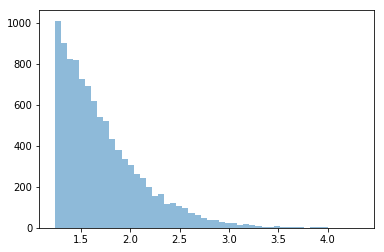

In [9]:
# p_data
xs = gen_conditional_samples(10000, gamma_0, sample_func)
n, bins, patches = plt.hist(xs, 50, alpha=0.5)

In [10]:
# one of the problem of GAN, easily to be more concentrated at "high mode"
# techniques such as minibatch discrimination might help

In [11]:
gamma_0

1.2327918305345862

In [12]:
### TODO: importance sampling GAN

In [13]:
# currently we focus on one dimension normal random variable, g(X) = X
# barrier func should be e^{-(x-y)^2}/2h-c/2(log(x-gamma)-log(y-gamma))^2
def compute_sp(dist_type):
    if dist_type == 'normal':
        def normal_sp(x, mu, sigma):
            return -(x-mu)/(2.0*sigma**2)
        return normal_sp

In [14]:
def compute_kernel_info(kernel_type):
    if kernel_type == 'normal_barrier':
        def normal_barrier(x, y, h, c, gamma):   #TODO: g(x) might be needed in the future, SymPy might be useful to compute symbolic derivative
            kernel_info = {}
            kernel_info['kernel'] = np.exp(-(x-y)*(x-y)/(2.0*h)-(c*(np.log(x-gamma)-np.log(y-gamma))*(np.log(x-gamma)-np.log(y-gamma)))/2.0)
            kernel_info['grad_x'] = kernel_info['kernel'] * (-(x-y)/h-c*(np.log(x-gamma)-np.log(y-gamma))/(x-gamma))
            kernel_info['grad_y'] = kernel_info['kernel'] * ((x-y)/h+c*(np.log(x-gamma)-np.log(y-gamma))/(y-gamma))
            kernel_info['hessian'] = kernel_info['grad_y']*(-(x-y)/h-c*(np.log(x-gamma)-np.log(y-gamma))/(x-gamma)) +\
            kernel_info['kernel']*(1.0/h+c/((x-gamma)*(y-gamma)))
            return kernel_info
        return normal_barrier

In [15]:
# compute kernel p
def compute_kernel_p(x, y, sp, kernel_info):
    kernel_vals = kernel_info(x,y)
    kernel = kernel_vals['kernel']
    grad_x = kernel_vals['grad_x']
    grad_y = kernel_vals['grad_y']
    hessian_kernel = kernel_vals['hessian']
    return sp(x)*kernel*sp(y) + sp(x)*grad_y + sp(y)*grad_x + hessian_kernel

In [16]:
# compute blackbox importance weights

In [17]:
def compute_Kp(samples, sp_input, ki_input):
    n = len(samples)
    Kp = np.zeros((n,n))
    p_kernel = partial(compute_kernel_p, sp=sp_input, kernel_info=ki_input)
    idx = np.array([[i, j] for i in range(n) for j in range(i, n)])
    s1 = samples[idx[:,0]]
    s2 = samples[idx[:,1]]
    res = p_kernel(s1, s2)
    Kp[np.triu_indices(n)] = res
    Kp = matrix(Kp.T+Kp-np.diag(np.diag(Kp)))
    return Kp

In [18]:
def compute_is_weights(Kp):
    n = Kp.size[0]
    p = matrix(0.0, (n,1))
    G = matrix(0.0, (n,n))
    G[::n+1] = -1.0
    h = matrix(0.0, (n,1))
    A = matrix(1.0, (1,n))
    b = matrix(1.0)
    res = solvers.qp(Kp, p, G, h, A, b)
    wi = np.array(res['x'])
    return wi

In [19]:
solvers.options['show_progress'] = False

In [24]:
class ISGAN(object):
    
    def __init__(self, gan_id, sess, total_epoch, batch_size, n_input, n_noise, n_hidden, early_stopping_rounds, learning_rate, gamma_0, is_enabled):
        self.gan_id = gan_id
        self.sess = sess
        self.total_epoch = total_epoch
        self.batch_size = batch_size
        self.n_input = n_input
        self.n_noise = n_noise
        self.n_hidden = n_hidden
        self.early_stopping_rounds = early_stopping_rounds
        self.learning_rate = learning_rate
        self.gamma_0 = gamma_0
        self.is_enabled = is_enabled
        if self.is_enabled:
            normal_sp = compute_sp('normal')
            self.std_normal_sp = partial(normal_sp, mu=0.0, sigma=1.0)
            normal_barrier = compute_kernel_info('normal_barrier')
            self.normal_barrier_param = partial(normal_barrier, h=1.0, c=1.0, gamma=self.gamma_0)
        
    def generator(self, noise_z):
        with tf.variable_scope('generator' + self.gan_id) :
            hidden_1 = tf.layers.dense(inputs=noise_z, units=self.n_hidden, activation=tf.nn.relu)
            hidden_2 = tf.layers.dense(inputs=hidden_1, units=self.n_hidden, activation=tf.nn.relu)
            output = tf.layers.dense(inputs=hidden_2, units=self.n_input, activation=tf.nn.softplus)
        return output

    def discriminator(self, inputs, reuse=None):
        with tf.variable_scope('discriminator' + self.gan_id) as scope:
            # In order to make the variables of the models that discriminate the actual image from the images generated by the noise the same,
            # Reuse the previously used variables.

            if reuse :
                scope.reuse_variables()

            hidden = tf.layers.dense(inputs=inputs, units=self.n_hidden, activation=tf.nn.relu)
            output = tf.layers.dense(inputs=hidden, units=self.n_input, activation=tf.nn.sigmoid)
        return output

    def get_noise(self, batch_size, n_noise) :
        #return (np.random.random(size=(batch_size, n_noise))-0.5)*2.0
        return np.random.normal(size=(batch_size, n_noise))
    
    def build_model(self):
        # input X
        self.X = tf.placeholder(tf.float32, [None, self.n_input])
        # Use noise Z as input value.
        self.Z = tf.placeholder(tf.float32, [None, self.n_noise])
        # Importance weights W
        self.W = tf.placeholder(tf.float32, [None, self.n_input])
        self.G = self.generator(self.Z)
        # Returns the value determined using the real image.
        self.D_real = tf.maximum(tf.minimum(self.discriminator(self.X), 0.99), 0.01)
        # Returns a value that determines whether the image created using noise is a real image.
        self.D_gene = tf.maximum(tf.minimum(self.discriminator(self.G, reuse=True), 0.99), 0.01)
        self.loss_D = tf.reduce_mean(tf.multiply(tf.log(self.D_real), self.W) + tf.log(1 - self.D_gene))
        #tf.summary.scalar('loss_D', -self.loss_D)
        self.loss_G = tf.reduce_mean(tf.log(self.D_gene))
        #tf.summary.scalar('loss_G', -self.loss_G)
        # When loss_D is obtained, only variables used in the generator neural network are used,
        vars_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator' + self.gan_id)
        vars_G = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator' + self.gan_id)
        # According to the GAN thesis formula, the loss should be maximized, but since the optimization function is used to minimize it, a negative sign is added to loss_D and loss_G to be optimized.
        self.train_D = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate).minimize(-self.loss_D, var_list=vars_D)
        #train_D = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(-loss_D, var_list=vars_D)
        self.train_G = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(-self.loss_G, var_list=vars_G)
        
    
    def train(self, sampling_func):
        self.histd, self.histg = [], []
        # Start training !
        k = 4
        self.sess.run(tf.global_variables_initializer())
        loss_val_D, loss_val_G = 0.0, 0.0
        prev_avg_D_cost = 0.0
        prev_avg_G_cost = 0.0
        for epoch in range(self.total_epoch):
            avg_D_cost = 0.0
            avg_G_cost = 0.0
            for i in range(self.early_stopping_rounds):
                for j in range(k):
                    batch_x = gen_conditional_samples(self.batch_size, self.gamma_0, sampling_func)
                    batch_x.sort() # it's better to sort the data first
                    if self.is_enabled == True:
                        Kp = compute_Kp(batch_x, self.std_normal_sp, self.normal_barrier_param)
                        is_weights = np.reshape(compute_is_weights(Kp), (self.batch_size, 1))
                    else:
                        is_weights = np.ones((self.batch_size, 1))
                    noise = self.get_noise(self.batch_size, self.n_noise)
                    noise.sort(axis=0)
                    # It learns discriminator and generator neural network separately.
                    _, loss_val_D = self.sess.run([self.train_D, self.loss_D],
                                                 feed_dict={self.X : np.reshape(batch_x, (self.batch_size, 1)), self.Z : noise, self.W: is_weights})
                    # replace np.ones with other weights
                self.histd.append(loss_val_D)
                noise = self.get_noise(self.batch_size, self.n_noise)
                noise.sort(axis=0)
                _, loss_val_G = self.sess.run([self.train_G, self.loss_G],
                                             feed_dict={self.Z : noise})
                self.histg.append(loss_val_G)
                avg_D_cost += loss_val_D / self.early_stopping_rounds
                avg_G_cost += loss_val_G / self.early_stopping_rounds
                #if (epoch*self.early_stopping_rounds+i) % (self.total_epoch * self.early_stopping_rounds//10) == 0:
                #    print(float(epoch*self.early_stopping_rounds+i)/float(self.total_epoch * self.early_stopping_rounds))
            # early stopping logic
            if np.abs(prev_avg_D_cost - avg_D_cost) < 0.0001 and np.abs(prev_avg_G_cost - avg_G_cost) < 0.0001:
                print("Stopping early, epoch = ", epoch)
                break
            prev_avg_D_cost = avg_D_cost
            prev_avg_G_cost = avg_G_cost
            if epoch % 10 == 0:
                print(epoch)
            #summary = sess.run(merged, feed_dict={X: np.reshape(batch_x, (batch_size, 1)), Z: noise})
            #writer.add_summary(summary, global_step=epoch)
                
    
    def gan_sampler(self, n):
        if n < self.batch_size:
            z = self.get_noise(self.batch_size, self.n_noise)
            gs = self.sess.run(self.G, {self.Z:z})
            return gs[:n][:,0]
        else:
            gs = np.zeros((n,self.n_input))
            div = n // self.batch_size
            rem = n % self.batch_size
            for i in range(div):
                z = self.get_noise(self.batch_size, 1)
                gs[self.batch_size*i:self.batch_size*(i+1)] = self.sess.run(self.G, {self.Z:z})
            z = self.get_noise(rem, self.n_noise)
            gs[div*self.batch_size:] = self.sess.run(self.G, {self.Z:z})
            return gs[:,0]

0
10
20
30
40
50
60
70
80
90
100
Stopping early, epoch =  104


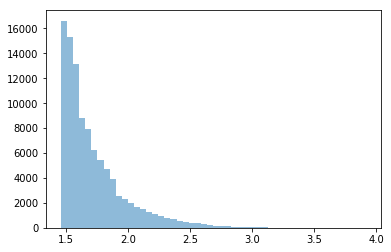

In [25]:
tf.reset_default_graph()
with tf.Session() as sess:
    gan = ISGAN('-1', sess, 5000, 200, 1, 1, 6, 50, 0.0003, gamma_0, False)
    gan.build_model()
    gan.train(sample_func) # input is weights
    gs = gan.gan_sampler(100000)
    n, bins, patches = plt.hist(gs, 50, alpha=0.5)

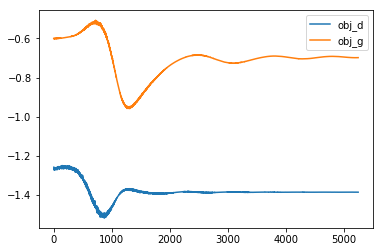

In [26]:
plt.plot(range(len(gan.histd)), gan.histd, label='obj_d')
plt.plot(range(len(gan.histg)), gan.histg, label='obj_g')
plt.legend()

In [27]:
gamma = 5
X = sample_func(1000)
gamma_0 = compute_gammak(X, 0.1)
X_0 = gen_conditional_samples(1000, gamma_0, sample_func)
sess = tf.Session()
gan = ISGAN('0', sess, 5000, 200, 1, 1, 6, 50, 0.0003, gamma_0, False)
gan.build_model()
gan.train(sample_func)
X_theta0 = gan.gan_sampler(1000)
cur_gamma = compute_gammak(X_theta0, 0.1)
idx = 1
prev_gan = gan
while cur_gamma < gamma:
#X_theta1 = gen_conditional_samples(1000, cur_gamma, gan.gan_sampler)
#conditional_gan_sampler = partial(gen_conditional_samples, gamma=cur_gamma, sample_func=gan.gan_sampler)
    cur_sess = tf.Session()
    cur_gan = ISGAN(str(idx), cur_sess, 5000, 200, 1, 1, 6, 50, 0.0003, cur_gamma, True)
    cur_gan.build_model()
    cur_gan.train(prev_gan.gan_sampler)
    cur_gamma = compute_gammak(cur_gan.gan_sampler(1000), 0.1)
    prev_gan = cur_gan
    idx += 1

    

0
10
20
30
40
50
60
Stopping early, epoch =  65
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
Stopping early, epoch =  356


ValueError: Rank(A) < p or Rank([P; A; G]) < n

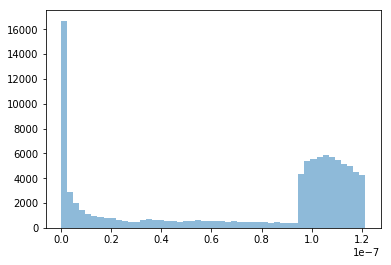

In [30]:
xs = prev_gan.gan_sampler(100000)
n, bins, patches = plt.hist(xs, 50, alpha=0.5)

In [37]:
import time
normal_sp = compute_sp('normal')
std_normal_sp = partial(normal_sp, mu=0.0, sigma=1.0)
normal_barrier = compute_kernel_info('normal_barrier')
normal_barrier_param = partial(normal_barrier, h=1.0, c=1.0, gamma=gamma_0)
batch_x = gen_conditional_samples(200, gamma_0, gan.gan_sampler)
start = time.time()
Kp = compute_Kp(batch_x, std_normal_sp, normal_barrier_param)
is_weights = np.reshape(compute_is_weights(Kp), (200, 1))
end = time.time()
print(end - start)


0.10655045509338379


In [40]:
is_weights

array([[1.81682108e-07],
       [1.63785066e-07],
       [2.68844352e-06],
       [2.60516683e-01],
       [3.75836373e-06],
       [9.31938171e-06],
       [1.11518783e-04],
       [1.82984279e-07],
       [3.16577017e-06],
       [5.90254699e-09],
       [1.14033412e-07],
       [2.47251981e-06],
       [7.15685860e-10],
       [1.61050118e-05],
       [3.09546082e-07],
       [1.75892645e-06],
       [5.33726350e-08],
       [2.13111481e-08],
       [6.44517221e-07],
       [4.15729638e-08],
       [4.14460838e-05],
       [8.47201321e-09],
       [5.65795439e-07],
       [1.70915120e-07],
       [1.61236344e-07],
       [5.63163314e-07],
       [2.14896984e-07],
       [3.84304619e-08],
       [6.68854953e-07],
       [2.37409615e-04],
       [2.85738962e-06],
       [2.66375452e-07],
       [1.91301893e-07],
       [6.24485675e-06],
       [5.43988514e-03],
       [1.32927353e-05],
       [5.54551044e-08],
       [1.02133837e-08],
       [1.45264707e-06],
       [3.13940185e-08],
